In [ ]:
# Check GPU
!nvidia-smi

# Install PyTorch with CUDA support
!pip install torch torchvision --quiet

# Optional: Install extra libs
!pip install scikit-learn matplotlib seaborn --quiet

print("Setup complete.")


Thu Nov 13 22:18:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   67C    P0             33W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/GMU/ECE 699 Robot Learning/dataset"   # CHANGE THIS to your actual dataset folder
print("Drive mounted.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted.


In [ ]:
import os

print("Checking dataset folder structure...\n")

for cls in os.listdir(DATA_DIR):
    cls_path = os.path.join(DATA_DIR, cls)

    # Skip hidden files like .DS_Store
    if not os.path.isdir(cls_path):
        print(f"Skipping non-directory: {cls}")
        continue

    num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(f"{cls}: {num_images} images")


Checking dataset folder structure...

Skipping non-directory: .DS_Store
cube: 775 images
cylinder: 778 images
sphere: 1182 images
cone: 728 images


In [ ]:
import os
import shutil

BAL_DIR = "/content/balanced_dataset"
os.makedirs(BAL_DIR, exist_ok=True)

classes = ["sphere", "cube", "cone", "cylinder"]
max_per_class = 700

for cls in classes:
    cls_in = os.path.join(DATA_DIR, cls)
    cls_out = os.path.join(BAL_DIR, cls)
    os.makedirs(cls_out, exist_ok=True)
    files = sorted(os.listdir(cls_in))[:max_per_class]
    print(f"{cls}: using {len(files)} images")

    for f in files:
        shutil.copy(os.path.join(cls_in, f), os.path.join(cls_out, f))

print("Balanced dataset created at:", BAL_DIR)


sphere: using 700 images
cube: using 700 images
cone: using 700 images
cylinder: using 700 images
Balanced dataset created at: /content/balanced_dataset


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

img_size = 128
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(8),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])



dataset = datasets.ImageFolder(root=BAL_DIR, transform=transform)
print("Classes:", dataset.classes)

indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_data = Subset(dataset, train_idx)
val_data   = Subset(dataset, val_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print("Train samples:", len(train_data))
print("Val samples:", len(val_data))


Using device: cuda
Classes: ['cone', 'cube', 'cylinder', 'sphere']
Train samples: 2237
Val samples: 560


In [ ]:
print("[INFO] Loading ConvNeXt_tiny...")

model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 4)
model = model.to(device)

# --- loss: light class weighting, NO label smoothing for now ---
# Make sure order matches dataset.classes: ['cone','cube','cylinder','sphere']
class_weights = torch.tensor([1.1, 1.0, 1.3, 0.7], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# --- optimizer & scheduler ---
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

num_epochs = 30  # give it a bit more room to learn
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("[INFO] Setup complete.")


[INFO] Loading ConvNeXt_tiny...
[INFO] Setup complete.


In [ ]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [ ]:
best_acc = 0.0
print("[INFO] Starting training...")

for epoch in range(num_epochs):
    tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Acc: {tr_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/content/best_tactile_classifier.pth")
        print("   [INFO] New best model saved.")

print("Training complete. Best Val Acc:", best_acc)


[INFO] Starting training...
Epoch [1/30] Train Acc: 62.76% | Val Acc: 65.00%
   [INFO] New best model saved.
Epoch [2/30] Train Acc: 71.21% | Val Acc: 69.29%
   [INFO] New best model saved.
Epoch [3/30] Train Acc: 76.08% | Val Acc: 74.11%
   [INFO] New best model saved.
Epoch [4/30] Train Acc: 81.22% | Val Acc: 73.93%
Epoch [5/30] Train Acc: 86.77% | Val Acc: 77.50%
   [INFO] New best model saved.
Epoch [6/30] Train Acc: 90.17% | Val Acc: 76.25%
Epoch [7/30] Train Acc: 92.80% | Val Acc: 77.14%
Epoch [8/30] Train Acc: 95.26% | Val Acc: 76.79%
Epoch [9/30] Train Acc: 96.20% | Val Acc: 78.93%
   [INFO] New best model saved.
Epoch [10/30] Train Acc: 97.27% | Val Acc: 77.32%
Epoch [11/30] Train Acc: 98.08% | Val Acc: 78.93%
Epoch [12/30] Train Acc: 98.70% | Val Acc: 77.50%
Epoch [13/30] Train Acc: 99.02% | Val Acc: 78.21%
Epoch [14/30] Train Acc: 99.20% | Val Acc: 80.18%
   [INFO] New best model saved.
Epoch [15/30] Train Acc: 99.46% | Val Acc: 79.82%
Epoch [16/30] Train Acc: 98.88% | Val A

Classification Report:
              precision    recall  f1-score   support

        cone       0.77      0.79      0.78       144
        cube       0.77      0.80      0.78       144
    cylinder       0.71      0.67      0.69       141
      sphere       1.00      1.00      1.00       131

    accuracy                           0.81       560
   macro avg       0.81      0.81      0.81       560
weighted avg       0.81      0.81      0.81       560



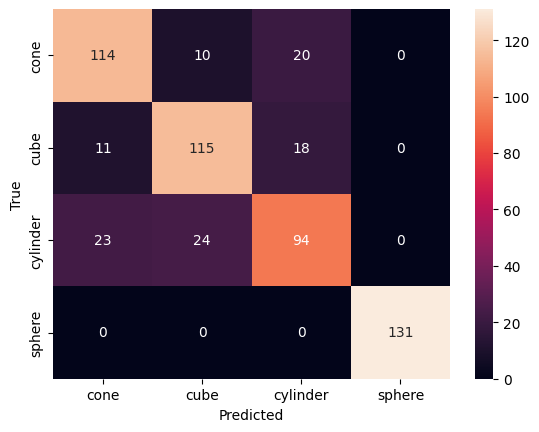

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from google.colab import files
files.download('/content/best_tactile_classifier.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>